<a href="https://colab.research.google.com/github/eliranshemtov/computer_vision/blob/main/CompVision_ex1_seam_carving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content aware image scaling by Seam Carving
In this exercise I implemented methods to scale images up and down while considering the content of the image, as well as removing unwanted objects from an image, using the same method. <br>

The original research paper that this exercise is based on could be found here: 
[Seam Carving, by Avidan and Shamir](https://faculty.idc.ac.il/arik/SCWeb/imret/imret.pdf)

# Preparations
Imports and loading the assets

In [1]:
import numpy as np
import cv2 as cv 
from google.colab.patches import cv2_imshow
from skimage import io
import matplotlib.pylab as plt

Loading a nice image of boat to scale up and down...


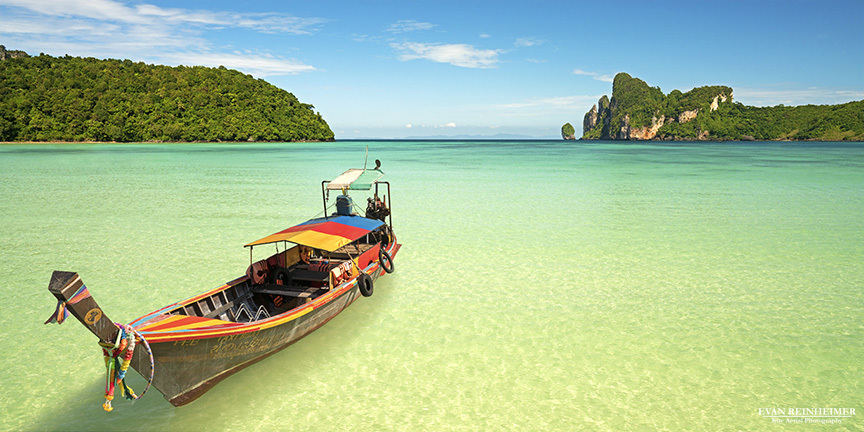

In [2]:
def load_image(url):
  image_url = url 
  image = cv.cvtColor(io.imread(image_url) , cv.COLOR_BGR2RGB)
  cv2_imshow(image)
  return image

print("Loading a nice image of boat to scale up and down...")
boat = load_image("https://cdn1.bigcommerce.com/server4200/oqjnq9/products/156/images/352/DSC00892qWEB__48005.1528914785.1280.1280.jpg")

# Calculating energy and seams maps
By applying a Gaussian filter to reduce noise and Sobel operator to compute an approximation of the gradient of the image intensity function. <br>
The energy function is the sum of absolute values of the partial derevative of x and the partial derevative of y for each pixel. <br>
The seams map is calculated using dynamic programming.

In [3]:
def calc_energy_map(image, scale=1, delta=2, ksize=3, filter_size=3):
  ddepth = cv.CV_16S
  image = cv.GaussianBlur(image, (filter_size, filter_size), 0)
  gray_level_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  gradient_x = cv.Sobel(gray_level_image, ddepth, 1, 0, ksize=ksize, scale=scale, delta=delta, borderType=cv.BORDER_CONSTANT)
  gradient_y = cv.Sobel(gray_level_image, ddepth, 0, 1, ksize=ksize, scale=scale, delta=delta, borderType=cv.BORDER_CONSTANT)
  abs_grad_x = cv.convertScaleAbs(gradient_x)
  abs_grad_y = cv.convertScaleAbs(gradient_y)
  return cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

In [4]:
def calc_vertical_seams_map(image, energy_map=None):
  if energy_map is not None:
    EM = energy_map
  else:
    EM = calc_energy_map(image)
  rows, columns = EM.shape
  paths_matrix = [[0 for i in range(columns)] for j in range(rows)]
  
  for y in range(1, rows):
    for x in range(columns):
      if x == 0:
        current_min_index = int(np.argmin(EM[y-1, x: x+2]))
        paths_matrix[y][x] = int(current_min_index + x)
        current_min_value = int(EM[y-1, current_min_index + x])
      else:
        current_min_index = int(np.argmin(EM[y-1, x-1:x+2]))
        paths_matrix[y][x] = int(current_min_index + x - 1)
        current_min_value = int(EM[y-1, current_min_index + x -1])
      EM[y,x] += current_min_value
  return EM, paths_matrix

Example of the "energy map" we are calculating:


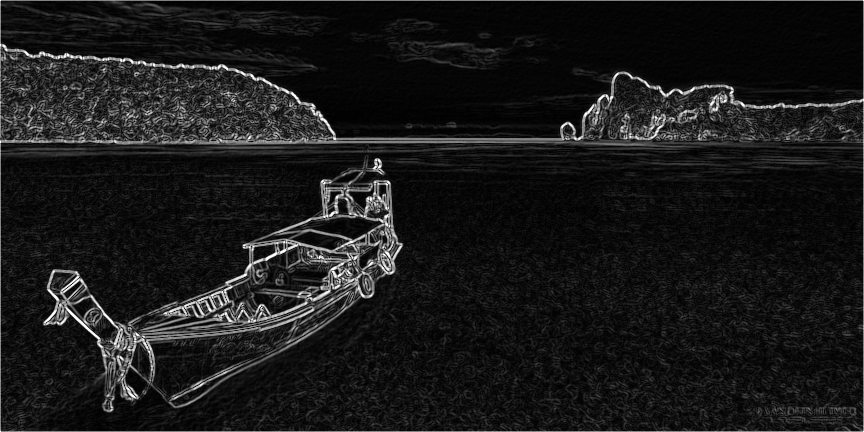

In [5]:
print('Example of the "energy map" we are calculating:')
cv2_imshow(calc_energy_map(boat))

# Scale down
By calculating the vertical seams and energy maps, creating a mask which "turns off" the pixel of the minimal seam and applying that mask on the image. <br>
This method also returns the removed vector.

In [6]:
def remove_minimal_seam(image, energy_map=None):
  """
  Find a minimal-energy-seam and remove it from the given image.
  First we calculate the energy map and paths (back-tracing), then we take the 
  minimal one and remove it by tracing back, bottom-up.
  also return the modified image along with the removed seam's vector.
  """
  energy_map, paths_matrix = calc_vertical_seams_map(image, energy_map)
  rows, columns = energy_map.shape
  seam_template = np.ones((rows, columns), dtype=np.bool)
  index_of_min_seams_end = np.argmin(energy_map[-1])
  seam_vector = list(range(rows))
  
  for y in reversed(range(rows)):
    seam_template[y, index_of_min_seams_end] = False
    seam_vector[y] = index_of_min_seams_end
    index_of_min_seams_end = paths_matrix[y][index_of_min_seams_end]
  
  seam_template = np.stack([seam_template] * 3, axis=2)
  image = image[seam_template].reshape((rows, columns-1, 3))
  return image, seam_vector

In [8]:
def remove_single_seam(image, seam_vec):
  rows = image.shape[0]
  columns = image.shape[1]
  seam_template = np.ones((rows, columns), dtype=np.bool)
  for y in reversed(range(rows)):
    seam_template[y, seam_vec[y]] = False
  
  seam_template = np.stack([seam_template] * 3, axis=2)
  image = image[seam_template].reshape((rows, columns-1, 3))
  return image

In [7]:
def remove_seams(image, seams):
  """
  Removes seams from the given image.
  """
  for s in seams:
    image.shape = image.shape[1], image.shape[0], image.shape[2]
    image = remove_single_seam(image, s)
  return image

## Scale down horizontally

In [9]:
def scale_down_horizontal(image, ratio, pre_calculated_seams_list=None):
  """
  Scale down an image by a given ratio.
  If pre_calculated_seams_list==None, each seam that will be removed will be the minimal and
  will be calculated in-place (by using remove_minimal_seam())
  """
  if 0 > ratio or ratio > 1:
    raise Exception("Scaling down expects ration between 0 and 1")
  print(f"Rescaling the given image by ratio of: {ratio}...")
  rows, columns, _ = image.shape
  num_of_iterations = int(columns - (columns * ratio))
  if not pre_calculated_seams_list or num_of_iterations > len(pre_calculated_seams_list):
    for x in range(num_of_iterations):
      image, _ = remove_minimal_seam(image)
  else:
    image = remove_seams(image, pre_calculated_seams_list[0:num_of_iterations])
  print("Done rescaling :)")
  return image

In [10]:
def calc_batch(image, n):
  """
  Offline preparation for scaling up or down: Remove n minimal seams from the 
  given image. Of course, re-calculate the minimal seam after each removal.
  Return the list of all removed seams by removal order ([0] is first, [n-1] was last removed).
  """
  removed_seams = list(range(n))
  for i in range(0, n):
    image, removed_seam_vector = remove_minimal_seam(image)
    removed_seams[i] = removed_seam_vector
  # [::-1] --> return reversed list
  return removed_seams[::-1]

## Usage example

In [ ]:
# Just to test, calc a batch of 250 seams
batch250 = calc_batch(boat, 250)

In [ ]:
# We can scale down the image by using the pre-calculated batch
scaled_down = scale_down_horizontal(boat, 0.9, batch250)

# Or without a pre-calculated batch. So every minimal seam will be calculated in place
# scaled_down = scale_down_horizontal(small_image, 0.8)

Rescaling the given image by ratio of: 0.9...
Done rescaling :)


Original size:


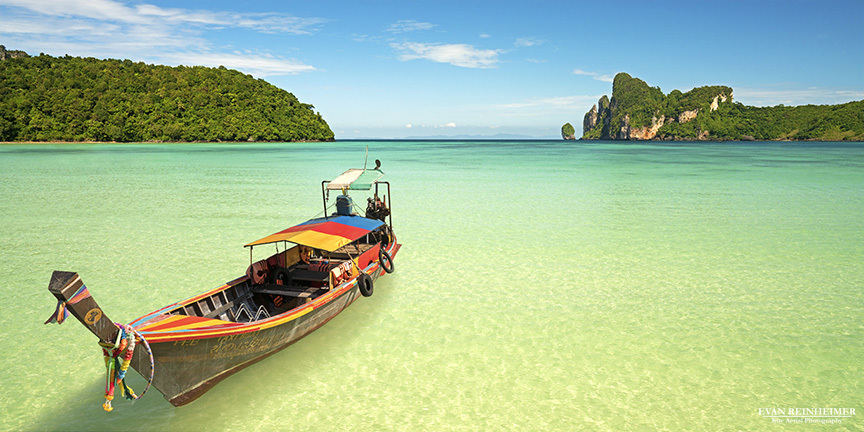

Scaled down * 0.9:


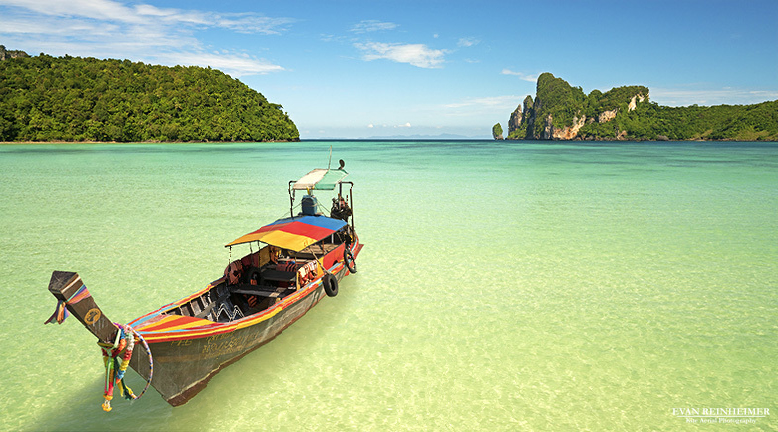

In [ ]:
print("Original size:")
cv2_imshow(boat)
print("Scaled down * 0.9:")
cv2_imshow(scaled_down)

## Scale down vertically

In [11]:
def rotate_scale_rotate(image, ratio, func, batch=None):
  """
  Helper function that rotates a given image, and scale-function which in turn
  receive the rotated image and the ratio. After scale function is applied, rotate
  back. Return: scaled image.
  """
  print("Rotating image...")
  rotated = cv.rotate(image, cv.ROTATE_90_CLOCKWISE)
  scaled = func(rotated, ratio, batch)
  print("Rotating back and returning the result")
  return cv.rotate(scaled, cv.ROTATE_90_COUNTERCLOCKWISE)

In [12]:
def scale_down_vertical(image, ratio, batch=None):
  return rotate_scale_rotate(image, ratio, scale_down_horizontal, batch)

## Usage example

In [ ]:
scaled_down = scale_down_vertical(boat, 0.8)

Rotating image...
Rescaling the given image by ratio of: 0.8...
Done rescaling :)
Rotating back and returning the result


Original size:


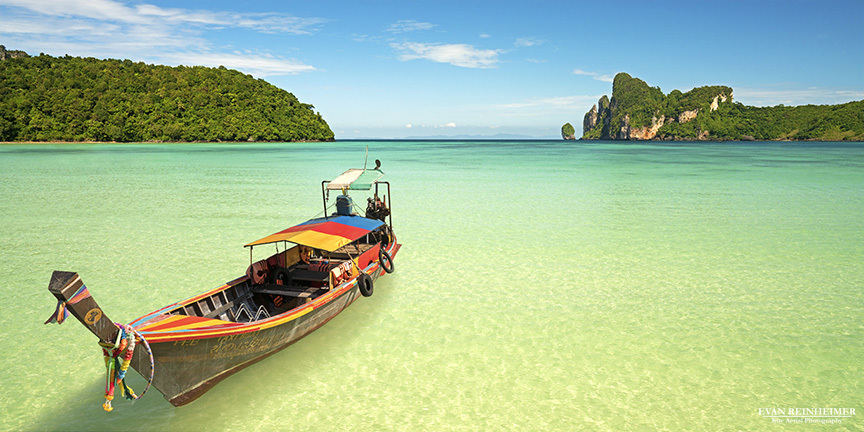

Scaled down vertically * 0.8:


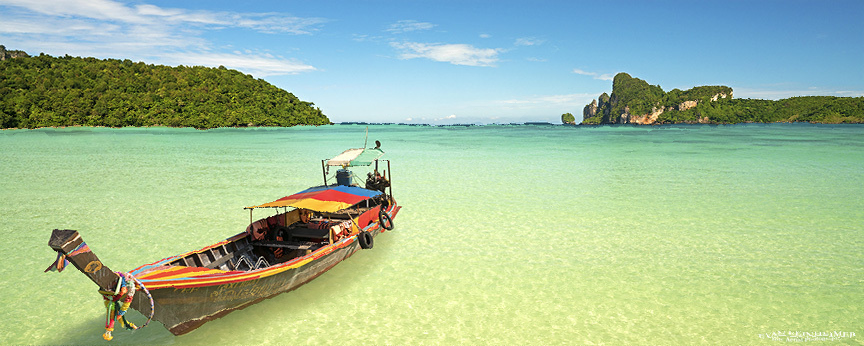

In [ ]:
print("Original size:")
cv2_imshow(boat)
print("Scaled down vertically * 0.8:")
cv2_imshow(scaled_down)

# Scale Up
To scale up an image we do seams removal without actually removing the seams, just memorizing the minimal seams that we wanted to remove. Those are the minimal seams that we could clone to expand the image. After doing so we have a list of the minimal seams at hand, so we can just clone them.

In [13]:
def clone_seam(image, seam_vec):
  """
  Clone a given seam vector by creating an empty larger image, and in each row
  draw all the pixels, until the given seam's pixel. Draw it too and then draw
  the average of the given seam's pixel and the next one (y, x+1). Continue with
  the rest of the pixels in the row.
  """
  height, width, dim = image.shape
  result = np.zeros((height, width+1, dim), np.float32)
  energy_map, paths_matrix = calc_vertical_seams_map(image)
  rows, columns = energy_map.shape

  for y in reversed(range(rows)):
    index_of_min_seams_end = seam_vec[y]
    vecs_avg = np.average(image[y, index_of_min_seams_end: index_of_min_seams_end+1], 0)
    tmp = np.concatenate((image[y, 0: index_of_min_seams_end+1], [vecs_avg]))
    result[y, :] = np.concatenate((tmp, image[y, index_of_min_seams_end+1: width]))
    index_of_min_seams_end = paths_matrix[y][index_of_min_seams_end]
  return result

In [14]:
def add_seams(image, seams):
  """
  Adds seams to the given image.
  """
  for s in seams:
    image = clone_seam(image, s)
  return image

## Scale up horizontally

In [15]:
def scale_up_horizontal(image, ratio=1, pre_calculated_seams_list=None, n=None):
  """
  Scale up a given image by a given ratio.
  If pre_calculated_seams_list==None, the seams
  to be duplicated will be batch-calculated in place (remove n seams from cloned
  image and return the list so it could be cloned one by one).
  """
  if ratio < 1:
    raise Exception("Scaling up requires ratio > 1")
  _, width, _ = image.shape
  n = n or int((width * ratio) - width)
  seams_list = pre_calculated_seams_list or calc_batch(image, n)

  return add_seams(image, seams_list)

## Usage example

Original Size:


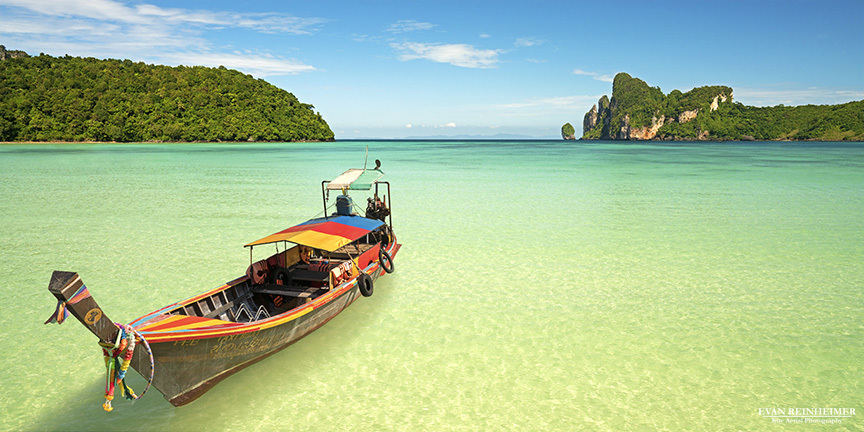

Scaled up horizontally by 1.2:


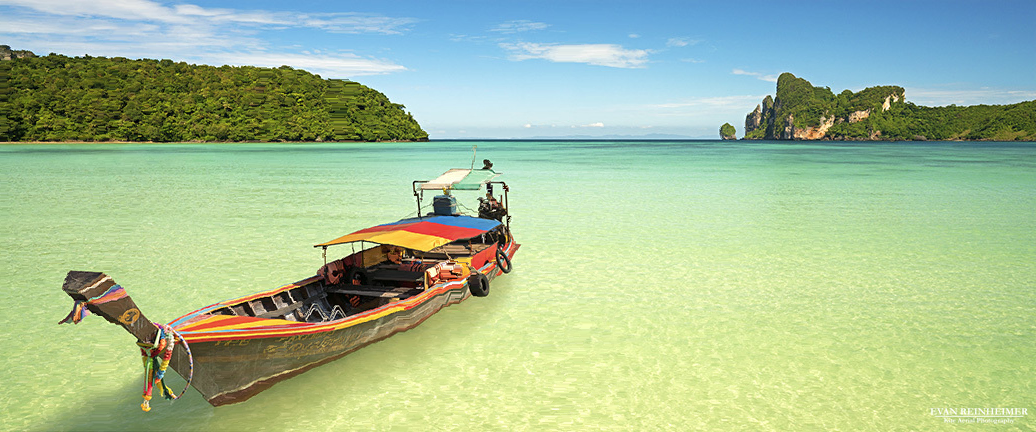

In [16]:
scaled_up = scale_up_horizontal(boat, 1.2)
print("Original Size:")
cv2_imshow(boat)
print("Scaled up horizontally by 1.2:")
cv2_imshow(scaled_up)

## Scale up vertically

In [17]:
def scale_up_vertical(image, ratio, batch=None):
  return rotate_scale_rotate(image, ratio, scale_up_horizontal, batch)

Rotating image...
Rotating back and returning the result


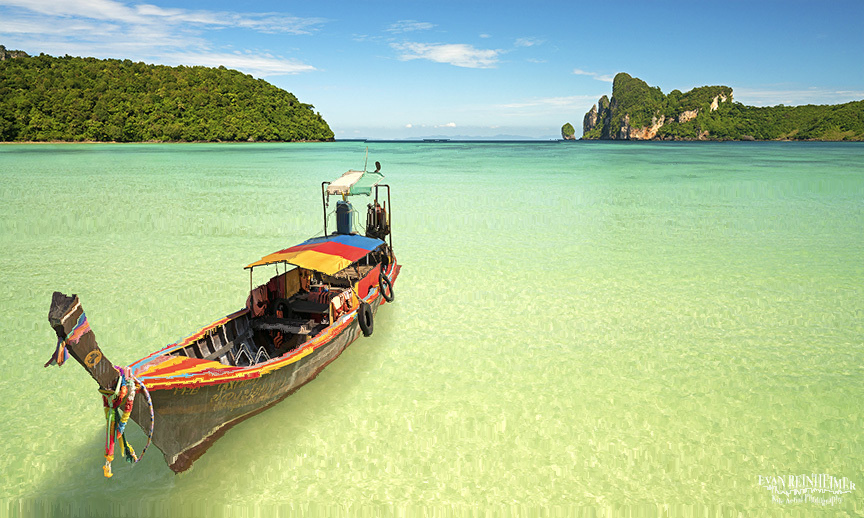

In [18]:
cv2_imshow(scale_up_vertical(boat, 1.2))

# Object removal by seam carving


## Object removal
Done by mentioning 2 points that describes a square that contains the obejct to remove. We create a mask of pixels to be removed according to those given points.<br>
We wish to remove as many seams as the square's width. for each seam to be removed, we calcualte an energy map. <br>
Every pixel in the energy map that the mask is applied on, will have a very low negative value, so seams that pass through it will always be minimal.

In [19]:
def remove_object(image, top_left: tuple, bottom_right: tuple):
  original_width = image.shape[0]
  for i in range(bottom_right[0]-top_left[0]):
    rows, columns, _ = image.shape
    mask = np.zeros((rows, columns), dtype=np.uint64)
    mask[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]-i] = 1
    energy_map = calc_energy_map(image).astype(np.int64)
    energy_map[mask.astype(bool)] = -99999
    image, seam = remove_minimal_seam(image, energy_map)
  recovered = scale_up_horizontal(image, n=bottom_right[0]-top_left[0])
  return recovered, image

## Usage example

Original image:


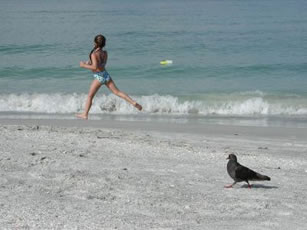

Object removed:


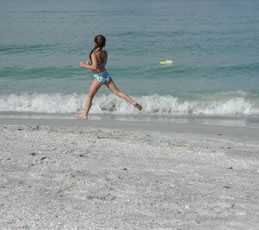

Object removed back in original size:


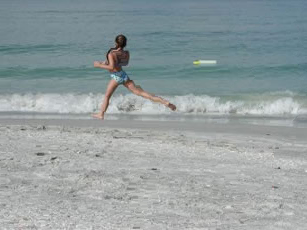

In [20]:
print("Original image:")
pigeon = load_image("https://faculty.idc.ac.il/arik/SCWeb/imret/results/Beach.jpg")

removed_with_original_size, removed = remove_object(pigeon, (226,153), (274,190))

print("Object removed:")
cv2_imshow(removed)
print("Object removed back in original size:")
cv2_imshow(removed_with_original_size)